In [2]:
# in this text, I set the reionization models within the constraint of Montero-Camacho & Mao, 2021.
# I use 2 points from the latest model to compute the compatability of the observation and the models
# the smoothing scale is reduced to 200 Mpc, in order to measure 2 points simultaneously

In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import time
import os
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal

import antisym_func
import error_bar #Tan
import error #Zhou

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
from importlib import reload
reload(error_bar)

<module 'error_bar' from '/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/error_bar.py'>

In [3]:
def setting_models(zeta, T_vir, R_mfp):
    """
    compute set the reionization model and gain its history
    -----------
    Parameters:
    -----------
    zeta : the ionizating efficiency
    T_vir : K, the virial temperature
    R_mfp : Mpc, the maximum radius of ionized bubbles
    --------
    Returns:
    --------
    zeta_z_func : the normalized zeta with respect to the redshift
    z_history, HI_history: the neutral fraction with respect to the redshift
    z_dxHdz_history, dxHdz_history : the reionization speed dx_HI/dz with respect to the redshift 
    max_speed : the maximum reionization speed
    turning_redshift : the redshift when the reionization speed reaches its maximum
    """
    tick = time.time()
    M_max = antisym_func.RtoM(R_mfp)
    mu = 1.22 if T_vir < 9.99999e3 else 0.6
    NUM = 60; z_zeta_interp_array = np.linspace(5.5, 16, NUM); zeta_z_interp_array = []
    for i in range(NUM):
        zeta_z_interp_array.append(antisym_func.zeta_z(z_zeta_interp_array[i], zeta, T_vir, mu))
    zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    z_history = np.linspace(5.5, 16, 200); HI_history = [];
    for z in z_history:
        HI_history.append(1 - antisym_func.bar_Q(z, M_max, zeta_z_func, T_vir, mu, antisym_func.PARA_z(z, M_max, zeta_z_func, T_vir, mu)))
    [z_dxHdz_history, dxHdz_history] = antisym_func.dxH_dz_cal(z_history, HI_history)
    max_speed = max(dxHdz_history)
    turning_redshift = z_dxHdz_history[dxHdz_history.index(max_speed)]  
    print('history comuputation at zeta=%4.4g T_vir=%4.4g cost %3.3g seconds'%(zeta, T_vir, time.time() - tick))
    return zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift

def tau(z_ion_he2, Delta_z_he2, z_history, HI_history):
    """
    compute the optical depth of elctron scattering (eqn 85 in Planck 2018:VI)
    -----------
    Parameters:
    -----------
    z : redshift we are interested in
    z_ion1, z_ion2 : the first and second helium reionization redshift, presumebly 3.5 and 7
    Delta_z1, Delta_z2 : the duaration of the helium reionization period, roughly 0.5
    z_history, HI_history: the neutral fraction with respect to the redshift
    --------
    Returns:
    --------
    x_e : the number density ratio of free electrons and hydrogen nuclei
    """
    f_He = 0.0811 #the number density ratio of helium to hydrogen nuclei, from 21cmFAST-v1.3
    n_H0 = 1.91795e-07 #cm^(-3), from 21cmFAST-v1.3
    sigma_T = 6.6524e-25 #cm^2, Thomson scattering cross section
    c_speed = 29979245800.0 #cm * s^(-1)
    
    #compute the he number density of free electrons from helium second ionization only and hydrogen nuclei
    Y_z = lambda z: (1 + z)**1.5
    Delta_y = lambda z, Delta_z: 1.5 * (1 + z)**0.5 * Delta_z
    x_e_helium = lambda z, z_ion, Delta_z: \
        f_He / 2 * (1 + np.tanh((Y_z(z_ion) - Y_z(z)) / Delta_y(z_ion, Delta_z))) 
    #compute the he number density of free electrons from hydrogen ionization only and hydrogen nuclei
    HI_func = interp1d(z_history, HI_history, kind = 'cubic')
    def x_e_hydrogen(z):
        if z < min(z_history): return 1
        elif z > max(z_history): return 0
        else:
            return 1 - HI_func(z)
        #+ x_e_helium(z, z_ion_he1, Delta_z_he1) 
    integrand = lambda z: (x_e_helium(z, z_ion_he2, Delta_z_he2) \
                          + (1+f_He) * x_e_hydrogen(z)) * (1 + z)**2 / (antisym_func.H_z(z) / 3.08567758128e19) #H(z) unit from km/s/Mpc to /s
    return n_H0 * sigma_T * c_speed * integrate.quad(integrand, 0, 15, epsrel = 1e-3)[0]

def model_constraint(max_speed_solution, z_mid_solution, zeta_assumed, T_vir_assumed,):
    def model_computation(parameters, xtol = 0.0001):
        zeta = parameters[0]; T_vir = parameters[1]
        eta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
            = setting_models(zeta, T_vir, 50)
        HI_func = interp1d(z_history, HI_history, kind = 'cubic')
        z_mid = fsolve(lambda z:HI_func(z) - 0.5, [8])
        print('max_speed =', max_speed, 'z_mid =', z_mid)
        return [max_speed - max_speed_solution, z_mid - z_mid_solution]
    zeta, T_vir = fsolve(model_computation, [zeta_assumed, T_vir_assumed])
    return zeta, T_vir

In [4]:
#check the certain model
zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
= setting_models(19.14 , 4.91E4 , 50)
HI_func = interp1d(z_history, HI_history, kind = 'cubic'); 
fsolve(lambda z:HI_func(z) - 0.5, [7])

history comuputation at zeta=19.14 T_vir=4.91e+04 cost 12.5 seconds


array([7.52095607])

history comuputation at zeta=19.14 T_vir=4.91e+04 cost 11.8 seconds
history comuputation at zeta=22.02 T_vir=4.33e+04 cost  12 seconds
history comuputation at zeta=25.14 T_vir=3.82e+04 cost 11.2 seconds


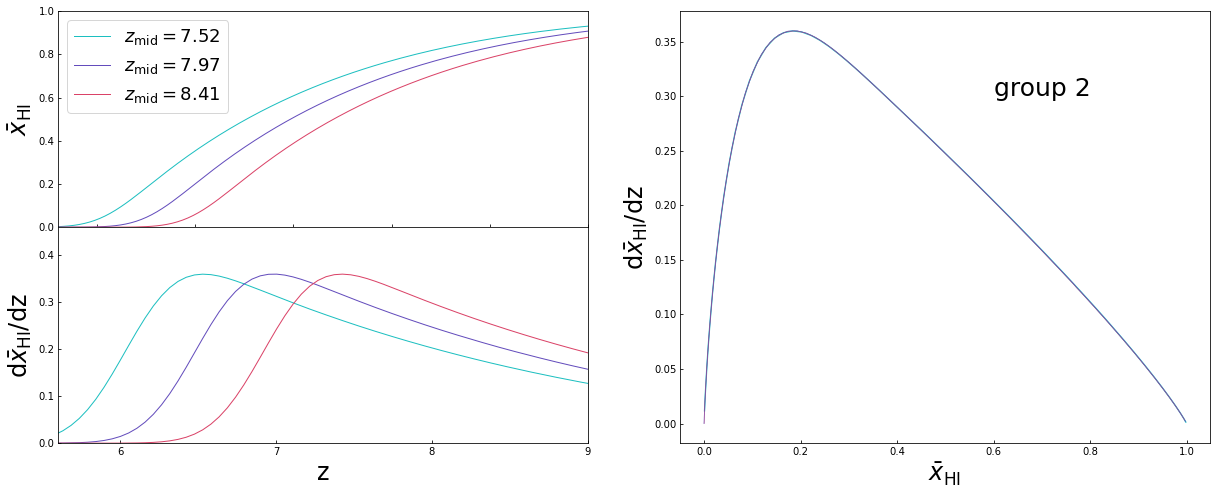

In [5]:
#plot the reionization history of group 2
zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift = \
[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]
zeta_array = [19.14, 22.02, 25.14]; T_vir_array = [4.91, 4.33, 3.82]
z_mid_array = [7.52, 7.97, 8.41]
for i in range(3):
    zeta = zeta_array[i]; T_vir = T_vir_array[i]
    zeta_z_func[i], z_history[i], HI_history[i], z_dxHdz_history[i], dxHdz_history[i], \
        max_speed[i], turning_redshift[i] = setting_models(zeta, T_vir * 1e4, 50)

plt.figure(figsize=(16,6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
max_dxHdz_array = [0.33, 0.36, 0.39, 0.42]
colorlist=['#1CBFC0', '#634CBC', '#DA4267', '#F87D31']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)
for i in range(3):
    ax1.plot(z_history[i], HI_history[i], color = colorlist[i], lw=1, label=r'$z_\mathrm{mid} = %4.4g $'%(z_mid_array[i]))
ax1.legend(fontsize=18, loc = 2)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5.6,9)
ax1.set_xticks([6,7,8,9,10,11])
ax1.set_xticklabels([])

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
for i in range(3):
    ax2.plot(z_dxHdz_history[i], dxHdz_history[i], color = colorlist[i], lw=1)
ax2.set_ylim(0.0,0.46); ax2.set_xlim(5.8,11.2)
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xticks([6,7,8,9,10,11])
ax2.set_xticklabels(['6','7','8','9','10','11'])
ax2.set_xlim(5.6,9)

ax3 = plt.subplot(122, position=[0.54,0.5,0.46,1])
lwlist = [1.3, 0.8, 0.3]
for i in range(3):
    ax3.plot(HI_history[i][:-1], dxHdz_history[i], color = colorlist[i], lw=lwlist[i])
ax3.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax3.set_xlabel(r'$\bar{x}_\mathrm{HI}$',fontsize=FONTSIZE)
ax3.tick_params(direction='in',length=3)
ax3.text(0.6, 0.3, 'group 2', fontsize = 25)
plt.savefig('../figures/history_groups_test_20230222.png', bbox_inches = 'tight', dpi=400)

In [6]:
#set the parameters
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
R_mfp = 50 #Mpc
M_max = antisym_func.RtoM(R_mfp)
mu = 0.6 #since all of T_vir > 1e4
SMOOTHING_Pk = 200
SMOOTHING_SCALE = 384

zeta_array = []; T_vir_array = [];#[group][model]
zeta_array.append([15.85, 18.07, 20.50]); T_vir_array.append([3.71e4, 3.25e4, 2.86e4])
zeta_array.append([19.14, 22.02, 25.14]); T_vir_array.append([4.91e4, 4.33e4, 3.82e4])
zeta_array.append([23.19, 26.82, 30.93]); T_vir_array.append([6.38e4, 5.62e4, 4.98e4])
max_dxHdz_array = [0.34, 0.36, 0.38] #[group]

In [27]:
#calculate the Pk_A for certain models at input redshift array
def read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE):
    #read in the normalized zeta
    DIR_zeta = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/normalized_zeta.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_zeta): 
        data = np.load(DIR_zeta)
        z_zeta_interp_array = data['z']; zeta_z_interp_array = data['zeta_z']
        zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_zeta); sys.exit()
        
    #read in the history of HI fraction and dx_HI/dz
    DIR_history = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_history):
        data = np.load(DIR_history)
        z_array_history = list(data['z_array_history']); HI_history = list(data['HI_history'])
        z_dxHdz_history = list(data['z_dxHdz_history']); dxHdz_history = list(data['dxHdz_history'])
    else:
        print('file %s not found'%DIR_history); sys.exit()
    
    #read in the average density of the neutral region
    DIR_rhoHI = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/rhoHI_over_rho0.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_rhoHI):
        data = np.load(DIR_rhoHI)
        z_array_HIrho = list(data['z_array_HIrho']); rhoHI_over_rho0_array = list(data['rhoHI_over_rho0_array'])
        HIrho_over_rho0_interp = interp1d(z_array_HIrho, rhoHI_over_rho0_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_rhoHI); sys.exit()
    
    #load in the Bubble mass functions
    DIR_BMF = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/BMF_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_BMF):
        data = np.load(DIR_BMF)
        z_grid = list(data['z_grid']); m_grid = list(data['m_grid']); BMF_map = list(data['BMF_map'])       
        BMF_interp = interp2d(m_grid, z_grid, BMF_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_BMF); sys.exit()
    
    #load in the unsmoothed antisymmetric cross-correlation data
    DIR_xiHICO = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/xi_A_HICO_unsmoothed_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_xiHICO):
        data = np.load(DIR_xiHICO)
        z_grid = list(data['z_grid']); r12_grid = list(data['r12_grid']); xi_A_HICO_map = list(data['xi_A_HICO_map'])       
        xi_A_HICO_unsmoothed_interp = interp2d(r12_grid, z_grid, xi_A_HICO_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_xiHICO); sys.exit()
    return zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
            BMF_interp, xi_A_HICO_unsmoothed_interp

def observation_parameters(z, NUM_PATCH, t_int, SMOOTHING_Pk, MEASUREMENT):
    """
    set the parameters for observation
    -----------
    Parameters:
    -----------
    z : redshift
    NUM_PATCH : number of observation boxes
    t_int : seconds, the observation time for the two lines
    MEASUREMENT: 0, 1, 2 for SKA1, SKA2 and SKA2-advanced
    """
    #set the parameters
    Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6 # muK
    Tsys_CO = 25 * 1e6 # muK
    D_21 = 35; D_CO = 15 # meter 
    Omega_beam_21 = (1.22 * error.lambda_21 * (1 + z) / D_21 ) ** 2
    Omega_beam_CO = (1.22 * error.lambda_CO * (1 + z) / D_CO ) ** 2 # radians
    delta_nu_21 = 5.4e-3; delta_nu_CO = 79.3e-3 #MHz
    
    #set the Parameters of telescopes
    if MEASUREMENT == 0: #parameters of SKA1 
        N_feeds_21 = 2 # num of polarizations
        N_feeds_CO = 197 * 2 # num of antennas * num of polarizations
        L_min_21 = 60; L_max_21 = 1000 #m
    elif MEASUREMENT == 1: #parameters of SKA2
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 1970 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    elif MEASUREMENT == 2: #parameters of SKA2-advanced
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 4925 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000
    
    #SMOOTHING_Pk defines the box size
    Omega_patch = (SMOOTHING_Pk * antisym_func.hlittle / error_bar.X(z)) ** 2
    Omega_survey = NUM_PATCH * Omega_patch
    delta_D = SMOOTHING_Pk * antisym_func.hlittle 
    return Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
            delta_nu_21, N_feeds_CO, N_feeds_21, t_int, t_int, delta_D, L_min_21, L_max_21

In [8]:
#read in the Pk_A_HICO data
DIR_read = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/data_model_independent_constraint_test/Pk_A_group_class/'

kh_array = np.logspace(np.log10(0.14),np.log10(0.6), 8)
k_array = kh_array * antisym_func.hlittle
z_acc_array = []; z_dec_array = [] #[group][model][z]
dxHdz_acc_array = []; dxHdz_dec_array = [] #[group][model][dxHdz]
Pk_A_acc_map = []; Pk_A_dec_map = [] #[group][model][dxHdz/z][kh]
for i in range(3): # 3 groups
    z_acc_array.append([]); z_dec_array.append([])
    dxHdz_acc_array.append([]); dxHdz_dec_array.append([])
    Pk_A_acc_map.append([]); Pk_A_dec_map.append([])
    for j in range(3): # 3 models in each group
        zeta = zeta_array[i][j]; T_vir = T_vir_array[i][j]
        data = np.load(DIR_read + 'zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g_LKS/Pk_A_acc_array.npz'%(zeta, T_vir, R_mfp, SMOOTHING_Pk))
        z_acc_array[-1].append(list(data['z_xi_acc_smoothed_array'])); dxHdz_acc_array[-1].append(list(data['dxHdz_xi_acc_smoothed_array']))
        Pk_A_acc_map[-1].append(list(data['Pk_A_acc_map'])); 
        data = np.load(DIR_read + 'zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g_LKS/Pk_A_dec_array.npz'%(zeta, T_vir, R_mfp, SMOOTHING_Pk))
        z_dec_array[-1].append(list(data['z_xi_dec_smoothed_array'])); dxHdz_dec_array[-1].append(list(data['dxHdz_xi_dec_smoothed_array'])) 
        Pk_A_dec_map[-1].append(list(data['Pk_A_dec_map']))



In [9]:
#read in the history and the HI-CO anti-symmtric cross correlation of the four analytical models
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/data_model_independent_constraint_test/xi_A_HICO'
zeta_z_func, z_HI_ana, HI_ana, z_dxHdz_ana, dxHdz_ana, HIrho_over_rho0_interp, BMF_interp, \
xi_A_HICO_unsmoothed_interp = [], [], [], [], [], [], [], [] #all of the arrays follows [group][model]
for i in range(3):
    zeta_z_func.append([]); z_HI_ana.append([]); HI_ana.append([])
    z_dxHdz_ana.append([]); dxHdz_ana.append([])
    HIrho_over_rho0_interp.append([]); BMF_interp.append([])
    xi_A_HICO_unsmoothed_interp.append([])
    for j in range(3):
        zeta_z_func[-1].append(0); z_HI_ana[-1].append(0); HI_ana[-1].append(0)
        z_dxHdz_ana[-1].append(0); dxHdz_ana[-1].append(0)
        HIrho_over_rho0_interp[-1].append(0); BMF_interp[-1].append(0)
        xi_A_HICO_unsmoothed_interp[-1].append(0)
        
for i in range(3):
    for j in range(3):
        zeta = zeta_array[i][j]; T_vir = T_vir_array[i][j]
        zeta_z_func[i][j], z_HI_ana[i][j], HI_ana[i][j], z_dxHdz_ana[i][j], dxHdz_ana[i][j],\
            HIrho_over_rho0_interp[i][j], BMF_interp[i][j], xi_A_HICO_unsmoothed_interp[i][j] \
            = read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE)
        

In [10]:
#compute the Delta_z defined in Monsalve et al. 2017
HI_func_map = []; dxHdz_func_map = []; Delta_z_map = []; Delta_z_map2 = []
for i in range(3):
    HI_func_map.append([]); dxHdz_func_map.append([]); Delta_z_map.append([]); Delta_z_map2.append([])
    for j in range(3):
        HI_func_map[-1].append(interp1d(z_HI_ana[i][j], HI_ana[i][j], kind = 'cubic'))
        dxHdz_func_map[-1].append(interp1d(z_dxHdz_ana[i][j], dxHdz_ana[i][j], kind = 'cubic'))
        z = fsolve(lambda z:HI_func_map[i][j](z) - 0.5, 8)
        if i == 1 and j == 0: print(z)
        Delta_z_map[-1].append(dxHdz_func_map[i][j](z) ** (-1))
        z_start = fsolve(lambda z:HI_func_map[i][j](z) - 0.75, 8)
        z_end = fsolve(lambda z:HI_func_map[i][j](z) - 0.25, 8)
        Delta_z_map2[-1].append(z_start - z_end)
Delta_z_groups = np.zeros(3); Delta_z_groups2 = np.zeros(3)
for i in range(3):
    for j in range(3):
        Delta_z_groups[i] += Delta_z_map[i][j]
        Delta_z_groups2[i] += Delta_z_map2[i][j]
    Delta_z_groups[i] /= 3
    Delta_z_groups2[i] /= 3
Delta_z_groups, Delta_z_groups2

[7.52096205]


(array([4.28375374, 3.99270891, 3.73159876]),
 array([2.3112162 , 2.15542979, 2.01552697]))

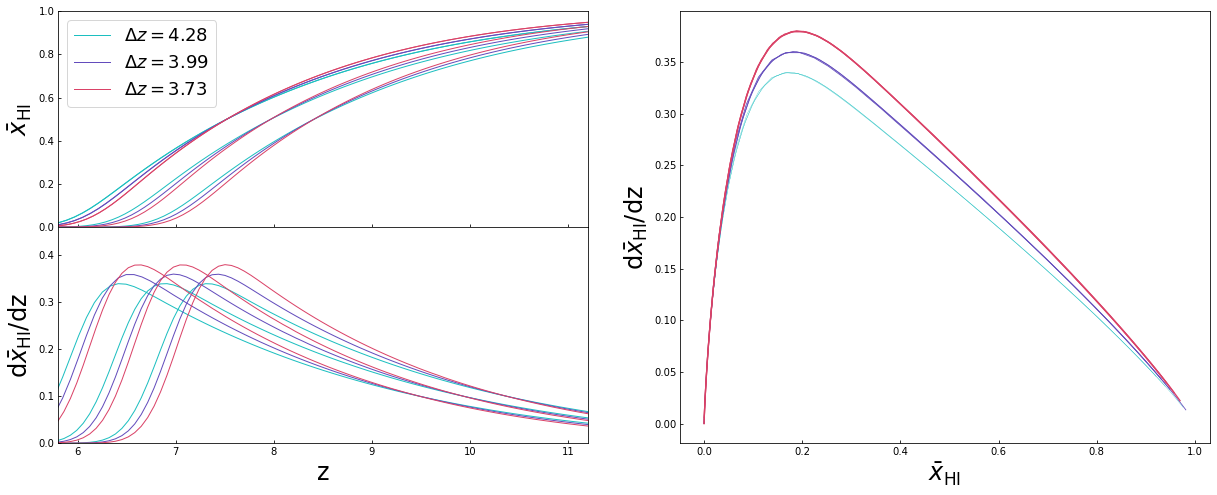

In [11]:
#read in the history of our groups
DIR_read = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/data_model_independent_constraint_test/xi_A_HICO/'

z_history_array = []; xH_history_array = []#[group][model]
z_dxHdz_history = []; dxHdz_history = []
for i in range(3): # 3 group
    z_history_array.append([]); xH_history_array.append([])
    z_dxHdz_history.append([]); dxHdz_history.append([])
    for j in range(3): # 3 model in each group
        zeta = zeta_array[i][j]; T_vir = T_vir_array[i][j]
        data = np.load(DIR_read + 'zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE))
        z_history_array[-1].append(list(data['z_array_history'])); xH_history_array[-1].append(list(data['HI_history']))
        z_dxHdz_history[-1].append(list(data['z_dxHdz_history'])); dxHdz_history[-1].append(list(data['dxHdz_history']))
        
plt.figure(figsize=(16,6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
colorlist=['#1CBFC0', '#634CBC', '#DA4267']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        if (j == 0):
            ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = colorlist[i], lw=1, label=r'$\Delta z = %3.3g$'%Delta_z_groups[i])
        ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = colorlist[i], lw=1)
ax1.legend(fontsize=18, loc = 2)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5.8,11.2)
ax1.set_xticks([6,7,8,9,10,11])
ax1.set_xticklabels([])

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        ax2.plot(z_dxHdz_history[i][j], dxHdz_history[i][j], color = colorlist[i], lw=1, label=r'$\zeta=%3.3g, T_\mathrm{vir}=%5.5g$'%(zeta_array[i][j], T_vir_array[i][j]))
ax2.set_ylim(0.0,0.46); ax2.set_xlim(5.8,11.2)
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xticks([6,7,8,9,10,11])
ax2.set_xticklabels(['6','7','8','9','10','11'])

ax3 = plt.subplot(122, position=[0.54,0.5,0.46,1])
lwlist = [0.3, 0.8, 1.3]
for i in range(3):
    for j in range(3):
        ax3.plot(xH_history_array[i][j][:-1], dxHdz_history[i][j], color = colorlist[i], lw=lwlist[i])
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
ax3.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax3.set_xlabel(r'$\bar{x}_\mathrm{HI}$',fontsize=FONTSIZE)
ax3.tick_params(direction='in',length=3)
#ax3.legend(fontsize=19, loc = 1)
#ax1.set_title('1')

plt.savefig('../figures/history_groups_model-independent_test_230309.png', bbox_inches = 'tight', dpi=400)

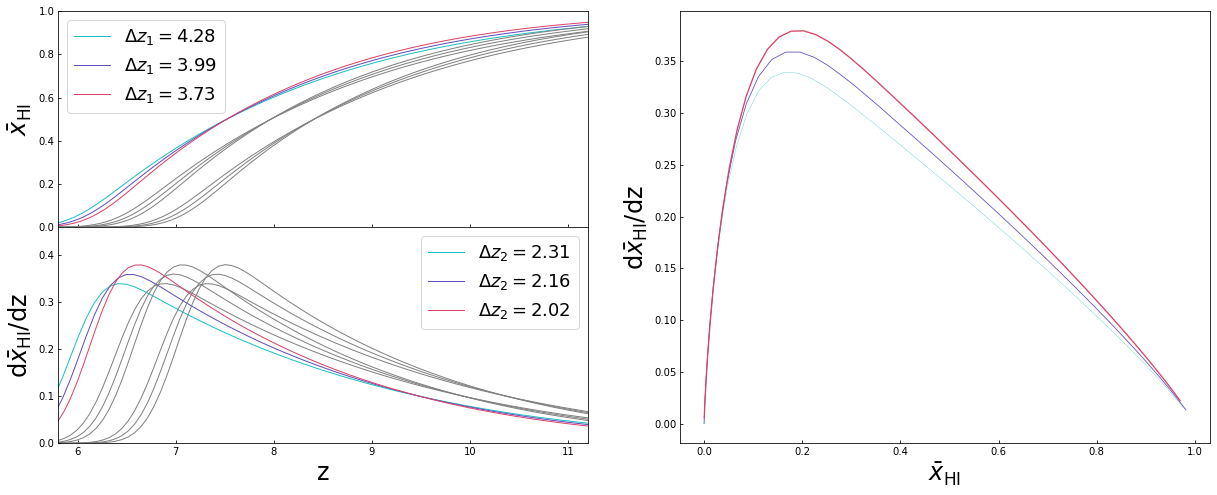

In [12]:
  plt.figure(figsize=(16,6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
colorlist=['#1CBFC0', '#634CBC', '#DA4267']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        if (j == 0):
            ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = colorlist[i], lw=1, label=r'$\Delta z_1 = %3.3g$'%Delta_z_groups[i])
        else:
            ax1.plot(z_history_array[i][j], xH_history_array[i][j], color = 'grey', lw=1)
ax1.legend(fontsize=18, loc = 2)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5.8,11.2)
ax1.set_xticks([6,7,8,9,10,11])
ax1.set_xticklabels([])

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
for i in range(3): # 3 groups
    for j in range(3): # 3 models in each group
        if (j == 0):
            ax2.plot(z_dxHdz_history[i][j], dxHdz_history[i][j], color = colorlist[i], lw=1, label=r'$\Delta z_2 = %3.3g$'%Delta_z_groups2[i])
        else:
            ax2.plot(z_dxHdz_history[i][j], dxHdz_history[i][j], color = 'grey', lw=1)
ax2.set_ylim(0.0,0.46); ax2.set_xlim(5.8,11.2)
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xticks([6,7,8,9,10,11])
ax2.set_xticklabels(['6','7','8','9','10','11'])
ax2.legend(fontsize=18, loc = 1)

ax3 = plt.subplot(122, position=[0.54,0.5,0.46,1])
lwlist = [0.3, 0.8, 1.3]
for i in range(3):
    for j in range(1):
        ax3.plot(xH_history_array[i][j][:-1], dxHdz_history[i][j], color = colorlist[i], lw=lwlist[i])
#axs.set_ylim(0.0,0.46); axs.set_xlim(6,11)
ax3.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax3.set_xlabel(r'$\bar{x}_\mathrm{HI}$',fontsize=FONTSIZE)
ax3.tick_params(direction='in',length=3)
#ax3.legend(fontsize=19, loc = 1)
#ax1.set_title('1')

plt.savefig('../figures/history_groups_model_one_230315.png', bbox_inches = 'tight', dpi=400)

In [14]:
# determine the survey volume to reach the minimum detection error
i = 1 # group 1
j = 0 # the latest model
z_index = -4

r12_limit = 150; r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]

#the 4th to the last point
zeta = zeta_array[i][j]; T_vir = T_vir_array[i][j]
z = z_acc_array[i][j][z_index]; dxHdz = dxHdz_acc_array[i][j][z_index]

xi_S_HICO_array, xi_auto_21_array = [], []
for r12 in r12_grid:
    xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func[i][j], HIrho_over_rho0_interp[i][j], lambda m: BMF_interp[i][j](m, z), M_max, T_vir_array[i][j], mu))
    xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func[i][j], HIrho_over_rho0_interp[i][j], lambda m: BMF_interp[i][j](m, z), M_max, T_vir_array[i][j], mu))    
xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')

In [28]:
# determine the survey volume to reach the minimum detection error

#SKA 2
N_PATCH = 2400
Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
                delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, t_int_21, delta_D, L_min_21, L_max_21 \
                = observation_parameters(z, N_PATCH, 16000 * 3600, SMOOTHING_Pk, 1)

Pk_A_acc_map_var, S_over_N = [], []
for kh_index in range(len(kh_array)):
    kh = kh_array[kh_index] # h/Mpc
    delta_kh = kh*0.23
    k = kh * antisym_func.hlittle # /Mpc
    P_CO_ana = antisym_func.Pk_auto_CO(z, k, T_vir_array[i][j], mu)
    P_21_ana = antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid))
    P_sym_ana = antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid))
    Pk_A_acc_map_var.append(error_bar.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
        Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
        t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc_map[i][j][z_index][kh_index])[0])
    S_over_N.append(abs(Pk_A_acc_map[i][j][z_index][kh_index]) / Pk_A_acc_map_var[kh_index])

#compute the confidence
square_sum = np.sum(np.array(S_over_N)**2)
free_degree = len(S_over_N)-1
confidence = error_bar.significance_level(square_sum, free_degree)
kh_min = kh_array[0]; kh_max = kh_array[free_degree]
while free_degree > 1:
    square_sum -= S_over_N[free_degree]**2
    free_degree -= 1 
    temp_confidence = error_bar.significance_level(square_sum, free_degree)
    #print(square_sum, free_degree, temp_confidence)
    if (temp_confidence > confidence):
        confidence = temp_confidence
        kh_max = kh_array[free_degree]


Omega_survey = N_PATCH * (200 * antisym_func.hlittle / error_bar.X(z)) ** 2
Omega_survey, confidence

(1.2348244065104121, 9.970189392373243)

In [29]:
#compute the 21cm and CO auto power spectrum and the symmetric HI-CO cross power spectrum
#at certain dxH/dz
r12_limit = 150; r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
Pk_A_acc_map_var, Pk_A_dec_map_var = [], [] #[group][model][dxHdz/z][kh]
for i in range(3): # 3 groups
    Pk_A_acc_map_var.append([]); Pk_A_dec_map_var.append([])
    for j in range(3): # 3 models in each group
        zeta = zeta_array[i][j]; T_vir = T_vir_array[i][j]
        Pk_A_acc_map_var[-1].append([]); Pk_A_dec_map_var[-1].append([])
        for z_index in range(len(z_acc_array[i][j])):
            z = z_acc_array[i][j][z_index]; dxHdz = dxHdz_acc_array[i][j][z_index]
            tick = time.time()
            #set the observation parameters
            Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, Omega_beam_CO, Omega_beam_21, delta_nu_CO, \
                delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, t_int_21, delta_D, L_min_21, L_max_21 \
                = observation_parameters(z, 2400, 16000 * 3600, SMOOTHING_Pk, 1)
            Pk_A_acc_map_var[-1][-1].append([])
            xi_S_HICO_array, xi_auto_21_array = [], []
            for r12 in r12_grid:
                xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func[i][j], HIrho_over_rho0_interp[i][j], lambda m: BMF_interp[i][j](m, z), M_max, T_vir_array[i][j], mu))
                xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func[i][j], HIrho_over_rho0_interp[i][j], lambda m: BMF_interp[i][j](m, z), M_max, T_vir_array[i][j], mu))    
            xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
            xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')
            for kh_index in range(len(kh_array)):
                kh = kh_array[kh_index] # h/Mpc
                delta_kh = kh*0.23
                k = kh * antisym_func.hlittle # /Mpc
                P_CO_ana = antisym_func.Pk_auto_CO(z, k, T_vir_array[i][j], mu)
                P_21_ana = antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid))
                P_sym_ana = antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid))
                Pk_A_acc_map_var[-1][-1][-1].append(error_bar.VAR_PA_k(kh, delta_kh, z, Omega_patch, NUM_PATCH, Tsys_CO, Tsys_21, \
                    Omega_beam_CO, Omega_beam_21, delta_nu_CO, delta_nu_21, Nfeeds_CO, Nfeeds_21, t_int_CO, \
                    t_int_21, delta_D, L_min_21, L_max_21, P_CO_ana, P_21_ana, P_sym_ana, Pk_A_acc_map[i][j][z_index][kh_index])[0])
            #print('%3.3g, %3.3g, %3.3g'%(Pk_A_acc_map_var[i][j][3][4] / Pk_A_acc_map[i][j][3][4] ))
            print('group %d model %d, at dxH/dz = %3.3g (acceleration) cost %3.3g mins'%(i, j, dxHdz, (time.time() - tick) / 60))

group 0 model 0, at dxH/dz = 0.225 (acceleration) cost 0.303 mins
group 0 model 0, at dxH/dz = 0.235 (acceleration) cost 0.294 mins
group 0 model 0, at dxH/dz = 0.245 (acceleration) cost 0.301 mins
group 0 model 0, at dxH/dz = 0.255 (acceleration) cost 0.3 mins
group 0 model 0, at dxH/dz = 0.265 (acceleration) cost 0.314 mins
group 0 model 0, at dxH/dz = 0.275 (acceleration) cost 0.314 mins
group 0 model 0, at dxH/dz = 0.285 (acceleration) cost 0.328 mins
group 0 model 0, at dxH/dz = 0.295 (acceleration) cost 0.344 mins
group 0 model 0, at dxH/dz = 0.305 (acceleration) cost 0.367 mins
group 0 model 0, at dxH/dz = 0.315 (acceleration) cost 0.38 mins


/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/error_bar.py:303: RuntimeWarning: invalid value encountered in double_scalars
  return VAR_PA_k**0.5, VAR_PA_k_cv**0.5 #return the sigma of error


group 0 model 0, at dxH/dz = 0.325 (acceleration) cost 0.37 mins
group 0 model 0, at dxH/dz = 0.335 (acceleration) cost 0.343 mins
group 0 model 1, at dxH/dz = 0.225 (acceleration) cost 0.305 mins
group 0 model 1, at dxH/dz = 0.235 (acceleration) cost 0.305 mins
group 0 model 1, at dxH/dz = 0.245 (acceleration) cost 0.31 mins
group 0 model 1, at dxH/dz = 0.255 (acceleration) cost 0.303 mins
group 0 model 1, at dxH/dz = 0.265 (acceleration) cost 0.304 mins
group 0 model 1, at dxH/dz = 0.275 (acceleration) cost 0.315 mins
group 0 model 1, at dxH/dz = 0.285 (acceleration) cost 0.346 mins
group 0 model 1, at dxH/dz = 0.295 (acceleration) cost 0.354 mins
group 0 model 1, at dxH/dz = 0.305 (acceleration) cost 0.379 mins
group 0 model 1, at dxH/dz = 0.315 (acceleration) cost 0.356 mins
group 0 model 1, at dxH/dz = 0.325 (acceleration) cost 0.353 mins
group 0 model 1, at dxH/dz = 0.335 (acceleration) cost 0.349 mins
group 0 model 2, at dxH/dz = 0.225 (acceleration) cost 0.303 mins
group 0 mode

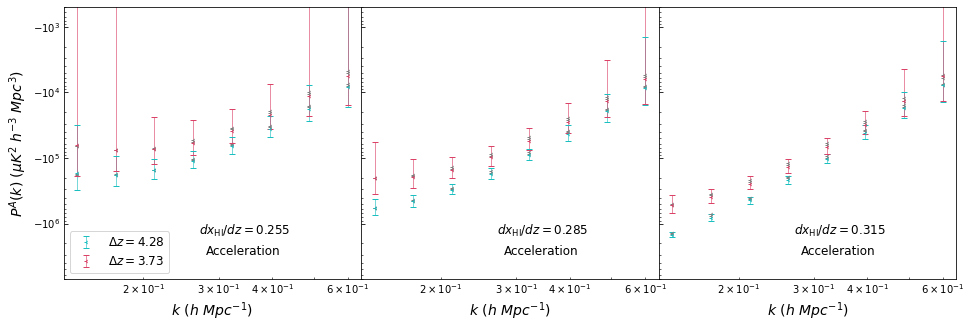

In [30]:
#plot the Pk_A_HICO comparison between different groups
COMPARISON_INDEX = [0, 2] # group number
colorlist=['#1CBFC0', '#634CBC', '#DA4267']
markerlist = ['3', '3', '3']
FONTSIZE = 14

dxHdz_plot_list = [0.255, 0.285, 0.315]
fig, axs = plt.subplots(1, 3, sharey=True, sharex = True, figsize=(16, 5))
fig.subplots_adjust(wspace=0, hspace = 0)
for ct in range(3): # dxHdz
    for i in COMPARISON_INDEX:
        for j in range(3): # model
            for dxHdz_index in range(len(dxHdz_acc_array[i][j])):
                dxHdz = round(dxHdz_acc_array[i][j][dxHdz_index],3)
                if dxHdz == dxHdz_plot_list[ct]:
                    if j == 0: axs[ct].errorbar(kh_array[0:], Pk_A_acc_map[i][j][dxHdz_index][0:], yerr = Pk_A_acc_map_var[i][j][dxHdz_index][0:], ls = '', marker = markerlist[j], markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, color = colorlist[i], label=r'$\Delta z = %3.3g$'%Delta_z_groups[i])
                    else: axs[ct].plot(kh_array[0:], Pk_A_acc_map[i][j][dxHdz_index][0:], ls='', marker = markerlist[j], markersize = 4, linewidth = 0.6, color = 'grey')
    axs[ct].text(0.27, 1.5e6, '$dx_\mathrm{HI} / dz = %3.3g$'%dxHdz_plot_list[ct], fontsize = FONTSIZE - 2)
    axs[ct].text(0.28, 3e6, 'Acceleration', fontsize= FONTSIZE - 2)
    axs[ct].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize = FONTSIZE)
    axs[ct].set_xticks([0.14,0.2,0.3,0.4,0.5,0.6])
    axs[ct].set_xticklabels(['0.14','0.2','0.3','0.4','0.5','0.6'])
    axs[ct].set_yscale('log'); axs[ct].set_xscale('log')
    #axs[i].loglog(np.linspace(0.1, 0.6, 100), PkA_simu_fit_plot, '-', color = 'black', linewidth = 1, label = '21cmFAST')
axs[0].set_ylabel(r'$P^A(k)$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)', fontsize = FONTSIZE)
axs[0].set_yticks([1e3, 1e4, 1e5, 1e6, 1e7])
axs[0].set_yticklabels(['$-10^{3}$','$-10^{4}$','$-10^{5}$','$-10^{6}$','$-10^{7}$'])
axs[0].set_ylim(5e2, 7e6)
axs[0].legend(loc=3, fontsize=FONTSIZE-2)

axs[0].invert_yaxis()
fig.savefig('../figures/Pk_A_HICO_groupclass_compare%d%d_LEN%d_t16000_modelindependent_test20230320.png'%(COMPARISON_INDEX[0], COMPARISON_INDEX[1], SMOOTHING_Pk), bbox_inches='tight', dpi=200)

In [31]:
#fit with errors
def fit_nR(kh_array, Pk_A_array, MEASURE, error = None):
    if (MEASURE == 1): #power law fitting
        def LS_PowerLaw_factor(k_local, A_R, n_R): #fit the power law between kh (0.14~0.26)
            func_form = A_R * k_local ** (-n_R)
            return func_form
        if error != None:
            popt, pocv = curve_fit(LS_PowerLaw_factor, kh_array, Pk_A_array, sigma = error, absolute_sigma=True, p0 = [Pk_A_array[-1],2])
        else:
            popt, pocv = curve_fit(LS_PowerLaw_factor, kh_array, Pk_A_array, p0 = [Pk_A_array[-1],2])
    if (MEASURE == 2):
        Pk_A_fit = [] #fitting in the loglog figure, increase the effect of large k part
        sigma_Pk_A_fit = []
        for i in range(len(Pk_A_array)):
            Pk_A_fit.append(np.abs(Pk_A_array[i]))
            sigma_Pk_A_fit.append(np.abs(error[i]))
        for i in range(len(Pk_A_fit)):
            if Pk_A_fit[i] - 0.5 * sigma_Pk_A_fit[i] > 0:
                sigma_Pk_A_fit[i] = np.log10(Pk_A_fit[i] + 0.5 * sigma_Pk_A_fit[i]) - np.log10(Pk_A_fit[i] - 0.5 * sigma_Pk_A_fit[i])
            else:
                sigma_Pk_A_fit[i] = np.log10(sigma_Pk_A_fit[i])
        def LS_PowerLaw_factor(k_local, A_R, n_R): #fit the power law between kh (0.14~0.26)
            func_form = A_R * k_local ** (-n_R)
            return np.log10(func_form)
        popt, pocv = curve_fit(LS_PowerLaw_factor, kh_array, np.log10(Pk_A_fit), sigma = sigma_Pk_A_fit, absolute_sigma=True, p0 = [np.log10(Pk_A_fit[-1]),2])
    return [popt[0], popt[1], pocv[0,0] ** 0.5, pocv[1,1] ** 0.5, pocv] #[A_R, n_R, errorbar for A_R, errorbar for n_R]

In [32]:
#set the fitting range
kh_array[0:4]

array([0.14      , 0.17235229, 0.21218081, 0.2612132 ])

In [43]:
covariance_matrix[1][0][-4], covariance_matrix[1][0][3]

(array([[ 4.83397526e+06, -6.89867236e+02],
        [-6.89867236e+02,  1.00371877e-01]]),
 array([[ 5.57531673e+09, -1.06171433e+05],
        [-1.06171433e+05,  2.05575967e+00]]))

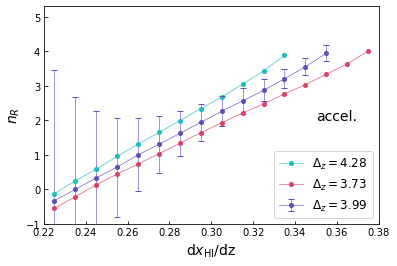

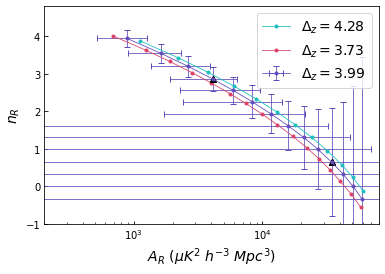

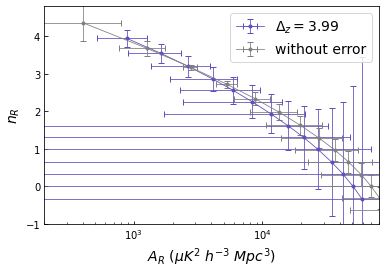

In [80]:
#calculate the powerlaw index n_R
kh_floor = 0; kh_ceil = 4 #in the range of (0.14, 0.27)
A_R_acc = []; n_R_acc = []; A_R_error_acc = []; n_R_error_acc = [] #[group][model][dxHdz]
covariance_matrix = []
for i in range(3): # 3 groups
    A_R_acc.append([]); n_R_acc.append([]); A_R_error_acc.append([]); n_R_error_acc.append([])
    covariance_matrix.append([])
    for j in range(3): # 3 models
        A_R_acc[-1].append([]); n_R_acc[-1].append([]); A_R_error_acc[-1].append([]); n_R_error_acc[-1].append([])
        covariance_matrix[-1].append([])
        for dxHdz_index in range(len(dxHdz_acc_array[i][j])):
            A_R_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1, Pk_A_acc_map_var[i][j][dxHdz_index][kh_floor:kh_ceil])[0])
            n_R_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1, Pk_A_acc_map_var[i][j][dxHdz_index][kh_floor:kh_ceil])[1])
            A_R_error_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1, Pk_A_acc_map_var[i][j][dxHdz_index][kh_floor:kh_ceil])[2])
            n_R_error_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1, Pk_A_acc_map_var[i][j][dxHdz_index][kh_floor:kh_ceil])[3])
            covariance_matrix[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1, Pk_A_acc_map_var[i][j][dxHdz_index][kh_floor:kh_ceil])[4])

#the case not considering the detection variance
A_R_acc2 = []; n_R_acc2 = []; A_R_error_acc2 = []; n_R_error_acc2 = [] #[group][model][dxHdz]
covariance_matrix2 = []
for i in range(3): # 3 groups
    A_R_acc2.append([]); n_R_acc2.append([]); A_R_error_acc2.append([]); n_R_error_acc2.append([])
    covariance_matrix2.append([])
    for j in range(3): # 3 models
        A_R_acc2[-1].append([]); n_R_acc2[-1].append([]); A_R_error_acc2[-1].append([]); n_R_error_acc2[-1].append([])
        covariance_matrix2[-1].append([])
        for dxHdz_index in range(len(dxHdz_acc_array[i][j])):
            A_R_acc2[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[0])
            n_R_acc2[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[1])
            A_R_error_acc2[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[2])
            n_R_error_acc2[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[3])
            covariance_matrix2[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[4])
            
            
FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,1,2]:
    for j in [0]:
        if i == 1: axs.errorbar(dxHdz_acc_array[i][j], n_R_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(dxHdz_acc_array[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', markersize = 4, linewidth = 0.6, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
axs.legend(fontsize=FONTSIZE-2, loc=4)
axs.set_xlabel(r'd$x_\mathrm{HI}$/dz',fontsize = FONTSIZE)
axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_xlim(0.22,0.38)
axs.set_ylim(-1,5.3)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
fig.savefig('../figures/nR_dxHdz_modelindependent_LEN384_t16000_MEASURE1_test20230315.png', bbox_inches='tight', dpi=200)

FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,1,2]:
    for j in [0]:
        if i == 1: axs.errorbar(A_R_acc[i][j], n_R_acc[i][j], xerr = A_R_error_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label='$\Delta_z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(A_R_acc[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', linestyle='-', markersize = 3, linewidth = 0.8, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
        axs.plot([A_R_acc[1][0][-4], A_R_acc[1][0][3]], [n_R_acc[1][0][-4], n_R_acc[1][0][3]], color = 'black', marker = '^', ls='None')
axs.legend(fontsize=FONTSIZE, loc=1)
axs.set_xlabel(r'$A_R$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)',fontsize=FONTSIZE)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
axs.set_xscale('log')
#axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_ylim(-1,4.8)
axs.set_xlim(2e2,80000)
fig.savefig('../figures/nR_AR_modelindependent_LEN384_t16000_MEASURE1_2point_test20230320.png', bbox_inches='tight', dpi=200)

FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [1]:
    for j in [0]:
        axs.errorbar(A_R_acc[i][j], n_R_acc[i][j], xerr = A_R_error_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label='$\Delta_z = %3.3g$'%Delta_z_groups[i])
        axs.errorbar(A_R_acc2[i][j], n_R_acc2[i][j], xerr = A_R_error_acc2[i][j], yerr = n_R_error_acc2[i][j], color = 'grey', fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label='without error'%Delta_z_groups[i])
axs.legend(fontsize=FONTSIZE, loc=1)
axs.set_xlabel(r'$A_R$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)',fontsize=FONTSIZE)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
axs.set_xscale('log')
#axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_ylim(-1,4.8)
axs.set_xlim(2e2,80000)
fig.savefig('../figures/nR_AR_error_effec_test20230315.png', bbox_inches='tight', dpi=200)

In [41]:
#the feasibility of computing the model compatibility with Multiple measured points
depth = 200
z1, z2 = z_acc_array[1][0][-4], z_acc_array[1][0][3]

z1, antisym_func.cal_z1_z2(z1, 200, 0)[1], antisym_func.cal_z1_z2(z2, 200, 0)[0], z2

(6.909120501893939, 7.195875495759962, 7.182339939009827, 7.484167850378788)

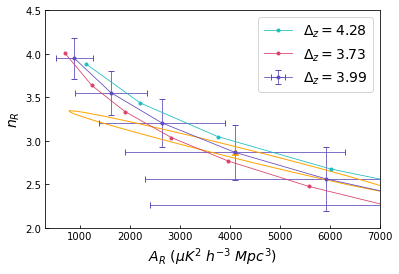

In [58]:
FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,1,2]:
    for j in [0]:
        if i == 1: axs.errorbar(A_R_acc[i][j], n_R_acc[i][j], xerr = A_R_error_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(A_R_acc[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', linestyle='-', markersize = 3, linewidth = 0.8, label='$\Delta_z = %3.3g$'%Delta_z_groups[i])

#I choose the point in the group i, model j, the nth to the last point
i = 1; j = 0; n = -4
mean = [A_R_acc[i][j][n], n_R_acc[i][j][n]]
covariance = covariance_matrix[i][j][n]
rv = multivariate_normal(mean, covariance)
CHI_SQUARE = 2.3
RHO = covariance[0,1] / covariance[0,0]**0.5 / covariance[1,1]**0.5
rv_sigma = []
rv_sigma.append(rv.pdf((mean[0], mean[1] + np.sqrt(CHI_SQUARE * (1 - RHO*RHO)) * covariance[1,1]**0.5)))
lim = dict()
lim['minvalx'] = mean[0] - 3 * covariance[0][0]**0.5
lim['maxvalx'] = mean[0] + 3 * covariance[0][0]**0.5
lim['minvaly'] = mean[1] - 3 * covariance[1][1]**0.5
lim['maxvaly'] = mean[1] + 3 * covariance[1][1]**0.5
xvals, yvals = np.mgrid[lim['minvalx']:lim['maxvalx']:.01*(lim['maxvalx']-lim['minvalx']), lim['minvaly']:lim['maxvaly']:.01*(lim['maxvaly']-lim['minvaly'])]
pos = np.dstack((xvals, yvals))
axs.contour(xvals, yvals, rv.pdf(pos), rv_sigma, colors=['orange'], linestyles=['solid','dashed','dotted'],linewidths=1) 
axs.plot([mean[0]], [mean[1]], marker = '^', color = 'orange')

axs.legend(fontsize=FONTSIZE, loc=1)
axs.set_xlabel(r'$A_R$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)',fontsize=FONTSIZE)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
#axs.set_xscale('log')
#axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_ylim(2, 4.5)
axs.set_xlim(300, 7000)

fig.savefig('../figures/nR_AR_1sigmacontour_test20230320_1.png', bbox_inches='tight', dpi=200)

In [62]:
def partial_diriv(matrix1, matrix2, theta1, theta2):
    '''
    compute the partial dirivative with respect to the parameter theta
    '''
    return (matrix1 - matrix2) / (theta1 - theta2)
    
def second_partial_diriv(matrix1, matrix2, matrix3, theta1, theta2, theta3):
    '''
    compute the second partial dirivative with respect to the same parameter theta
    '''
    dM_dtheta1 = (matrix1 - matrix2) / (theta1 - theta2)
    theta_dM_dtheta1 = (theta1 + theta2) / 2
    dM_dtheta2 = (matrix2 - matrix3) / (theta2 - theta3)
    theta_dM_dtheta2 = (theta2 + theta3) / 2
    return (dM_dtheta1 - dM_dtheta2) / (theta_dM_dtheta1 - theta_dM_dtheta2)
    
def T_matrix(func, X):
    '''
    compute the partial dirivative matrix of the model with respect to the input X
    in our case, the function is the interpolation and X is the slope n_R
    return the diagonal matrix T
    '''
    X_len = len(X)
    T = np.matrix(np.zeros((X_len, X_len)))
    for i in range(X_len):
        partial_diriv = (func(X[i] * 1.01) - func(X[i] * 0.99)) / (X[i] * 0.02)
        T[i,i] = partial_diriv
    return T

def generalized_fisher_matrix(X, Y, C_XX, C_XY, C_YY, SIGMA, interp_func_3, Delta_z_3):
    '''
    compute the parameter estimation through the generalized fisher matrix of model f(X, Y| Delta_z)
    X, Y : each array containing a set of measurements, (X_i, Y_i) represent the ith measured data point
    X : [X_1, X_2, ..., X_N], in our case the slope of the dipole, n_R
    Y : [Y_1, Y_2, ..., Y_N], in our case the slope of the dipole, A_R
    C_XX, C_YY : the covariance of X, Y
    C_XY : the meta-covarance between X and Y
    SIGMA : the variance of X, a diagonal matrix, C_XX in our case 
    interp_func_3 : [interp1, interp2, interp3], the 3 interpolated function of analytical model points
    Delta_z_3 : [Delta_z_1, Delta_z_2, Delta_z_3], the 3 EoR duration corresponding to the 3 interpolations
    '''
    # the 3 matrix corresponding to the 3 
    mu_3 = [np.matrix([[float(interp_func(X_i))] for X_i in X]) for interp_func in interp_func_3]
    T_3 = [T_matrix(interp_func, X) for interp_func in interp_func_3]
    R_3 = [C_YY - C_XY.T * T.T - T * C_XY + T * C_XX * T.T for T in T_3]
    R = R_3[1] # the data points are on the middle function 
    
    dR_dDeltaz = partial_diriv(R_3[0], R_3[2], Delta_z_3[0], Delta_z_3[2])
    dmu_dDeltaz = partial_diriv(mu_3[0], mu_3[2], Delta_z_3[0], Delta_z_3[2])
    
    F0_DeltazDeltaz = 0.5 * np.trace(R.I * dR_dDeltaz * R.I * dR_dDeltaz + R.I * (dmu_dDeltaz * dmu_dDeltaz.T + dmu_dDeltaz * dmu_dDeltaz.T) )
    
    E = (C_YY - C_XY.T * C_XX.I * C_XY).I
    H = C_XX.I * C_XY * E
    G = C_XX.I + C_XX.I * C_XY * E * C_XY.T * C_XX.I
    
    F1_term1 = 0 # the 1st term in the first order approximation of Fisher matrix, F1_DeltazDeltaz
    A_3 = [G + T_3[i].T * E * T_3[i] - H * T_3[i] - T_3[i].T * H.T for i in range(3)]
    A = A_3[1] # the data points are on the middle function 
    F1_term1 += SIGMA.I * second_partial_diriv(A_3[0].I, A_3[1].I, A_3[2].I, Delta_z_3[0], Delta_z_3[1], Delta_z_3[2])
    temp_3 = [(H.T - E * T_3[i]) * A_3[i].I * SIGMA.I * A_3[i].I * (H - T_3[i].T * E) for i in range(3)]
    F1_term1 += second_partial_diriv(temp_3[0], temp_3[1], temp_3[2], Delta_z_3[0], Delta_z_3[1], Delta_z_3[2]) * R 
    F1_term1 = 0.5 * np.trace(F1_term1)
    
    #in our case, X = a. So the 2nd and the 3rd term in F1 equals zero
    
    F1_term4 = partial_diriv(mu_3[0].T, mu_3[2].T, Delta_z_3[0], Delta_z_3[2]) * temp_3[1] \
                * partial_diriv(mu_3[0], mu_3[2], Delta_z_3[0], Delta_z_3[2])
    
    F1_DeltazDeltaz = F1_term1 + F1_term4[0,0]
    F_DeltazDeltaz = F0_DeltazDeltaz + F1_DeltazDeltaz
    
    return (1 / F_DeltazDeltaz) ** 0.5

In [66]:
#we use only the 4 to the last measured point of the middle model
index1 = -4; index2 = 3
interp_func_3 = [interp1d(n_R_acc[i][0], A_R_acc[i][0], kind = 'cubic') for i in range(3)]
X = np.matrix([n_R_acc[1][0][index1], n_R_acc[1][0][index2]]).T #n_R
Y = np.matrix([A_R_acc[1][0][index1], A_R_acc[1][0][index2]]).T #A_R
C_XX = np.matrix(np.diag([covariance_matrix[1][0][index1][1][1], covariance_matrix[1][0][index2][1][1]]))
C_XY = np.matrix(np.diag([covariance_matrix[1][0][index1][0][1], covariance_matrix[1][0][index2][0][1]]))
C_YY = np.matrix(np.diag([covariance_matrix[1][0][index1][0][0], covariance_matrix[1][0][index2][0][0]]))
SIGMA = C_XX  

sigma_Delta_z = generalized_fisher_matrix(X, Y, C_XX, C_XY, C_YY, SIGMA, interp_func_3, Delta_z_groups)
print('\sigma_{\Delta z} = %3.3g'%sigma_Delta_z)

\sigma_{\Delta z} = 0.191


[0.11726667402614907, 0.08315238252081611, 0.05979927540361313, 0.04469107590821101, 0.03334521169097489, 0.026512942910454945, 0.021672326038841012, 0.018303997833598668, 0.016030595018001553, 0.014724726873488912, 0.013991860060353245, 0.013686395952461558, 0.0137599187813417, 0.014158617252569498]


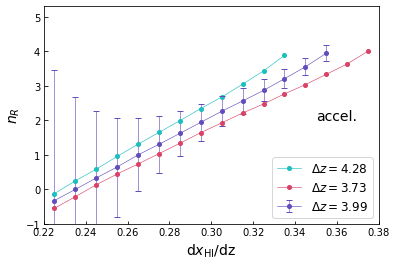

In [72]:
#compute the variance of the dxH/dz with the constraint of the groups
FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,1,2]:
    for j in [0]:
        if i == 1: axs.errorbar(dxHdz_acc_array[i][j], n_R_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 4, linewidth = 0.6, capsize = 3, capthick = 1, label = '$\Delta z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(dxHdz_acc_array[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', markersize = 4, linewidth = 0.6, label = '$\Delta z = %3.3g$'%Delta_z_groups[i])
axs.legend(fontsize=FONTSIZE-2, loc=4)
axs.set_xlabel(r'd$x_\mathrm{HI}$/dz',fontsize = FONTSIZE)
axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_xlim(0.22,0.38)
axs.set_ylim(-1,5.3)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)

def dxHdz_constraint(dxHdz_acc_3, n_R_3, n_R_error_3, Delta_z_3, sigma_Delta_z):
    """
    compute the variance of dxH/dx of group 2 (the middle one) with the constraint of Delta_z 
    dxHdz_acc_3 : [group]
    n_R_3 : [group]
    n_R_error_3 : [group]
    sigma_Delta_z : the 1-sigma vairance of the reionization duration
    """
    dxHdz_func = lambda n_R, k, b: k * n_R + b
    k, b = [], []
    for i in range(3):
        popt, pcov = curve_fit(dxHdz_func, n_R_3[i], dxHdz_acc_3[i])
        k.append(popt[0]); b.append(popt[1])
    sigma_dxHdz = []
    for ct in range(len(n_R_3[1])):
        n_R = n_R_3[1][ct]; sigma_n_R = n_R_error_3[1][ct]
        dv_dnR = k[1]
        dv_dDeltaz = abs(dxHdz_func(n_R, k[0], b[0]) - dxHdz_func(n_R, k[2], b[2])) / abs(Delta_z_3[0] - Delta_z_3[2])
        variance = dv_dnR**2 * sigma_n_R**2 + dv_dDeltaz**2 * sigma_Delta_z**2
        sigma_dxHdz.append(variance**0.5)
    return sigma_dxHdz

dxHdz_acc_3, n_R_3, n_R_error_3 = [], [], []
for i in range(3):
    dxHdz_acc_3.append(dxHdz_acc_array[i][0])
    n_R_3.append(n_R_acc[i][0])
    n_R_error_3.append(n_R_error_acc[i][0])

sigma_dxHdz_10_array = dxHdz_constraint(dxHdz_acc_3, n_R_3, n_R_error_3, Delta_z_groups, sigma_Delta_z)
print(sigma_dxHdz_10_array)

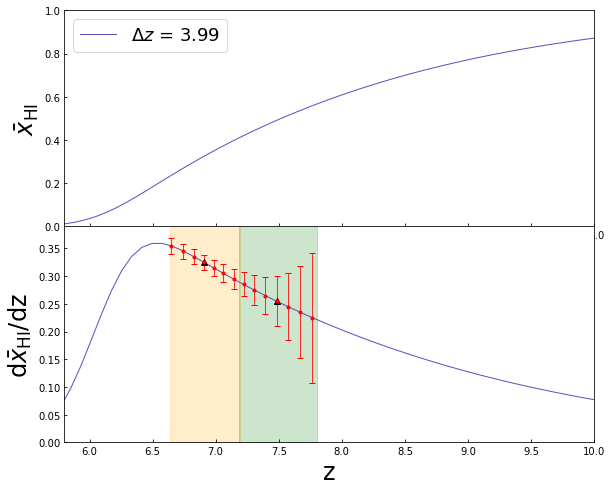

In [79]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(16, 6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
colorlist=['#1CBFC0', '#634CBC', '#DA4267']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)

ax1.plot(z_history_array[1][0], xH_history_array[1][0], color = colorlist[1], lw=1, label=r'$\Delta z$ = %3.3g'%Delta_z_groups[1])
ax1.legend(fontsize=18, loc = 2)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5.8,10)
#ax1.set_xticks([6,7,8])

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
ax2.plot(z_dxHdz_history[1][0], dxHdz_history[1][0], color = colorlist[1], lw=1, label=r'$\zeta=%3.3g, T_\mathrm{vir}=%5.5g$'%(zeta_array[i][j], T_vir_array[i][j]))
ax2.errorbar(z_acc_array[1][0], dxHdz_acc_array[1][0], ls = 'None', yerr = sigma_dxHdz_10_array, color = 'red', lw = 0.8, capsize = 3, marker = '.')
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xlim(5.8,10)
ax2.set_ylim(0.0,0.39)
#ax2.set_xticks([6,7,8])

#plot the point and its smoothing range we choose to fit the duration group
ax2.plot([z_acc_array[1][0][-4], z_acc_array[1][0][3]], [dxHdz_acc_array[1][0][-4], dxHdz_acc_array[1][0][3]], marker = '^', color = 'black',ls = 'None')
z_left, z_right = antisym_func.cal_z1_z2(z_acc_array[1][0][-4], 200, 0)
ax2.fill_between(np.linspace(z_left, z_right, 20), 0.4, 0, alpha = 0.2, color = 'orange')

z_left, z_right = antisym_func.cal_z1_z2(z_acc_array[1][0][3], 200, 0)
ax2.fill_between(np.linspace(z_left, z_right, 20), 0.4, 0, alpha = 0.2, color = 'green')

fig.savefig('../figures/history_dxHdz_constraint_2point_230320.png', bbox_inches='tight', dpi=200)

(300.0, 7000.0)

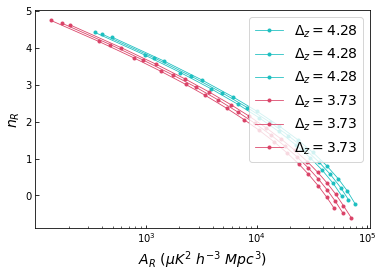

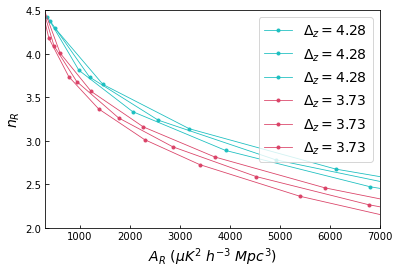

In [136]:
#for test!!!!!

#calculate the powerlaw index n_R
kh_floor = 0; kh_ceil = 4 #in the range of (0.14, 0.27)
A_R_acc = []; n_R_acc = []; A_R_error_acc = []; n_R_error_acc = [] #[group][model][dxHdz]
covariance_matrix = []
for i in range(3): # 3 groups
    A_R_acc.append([]); n_R_acc.append([]); A_R_error_acc.append([]); n_R_error_acc.append([])
    covariance_matrix.append([])
    for j in range(3): # 3 models
        A_R_acc[-1].append([]); n_R_acc[-1].append([]); A_R_error_acc[-1].append([]); n_R_error_acc[-1].append([])
        covariance_matrix[-1].append([])
        for dxHdz_index in range(len(dxHdz_acc_array[i][j])):
            A_R_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[0])
            n_R_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[1])
            A_R_error_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[2])
            n_R_error_acc[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[3])
            covariance_matrix[-1][-1].append(fit_nR(kh_array[kh_floor:kh_ceil], Pk_A_acc_map[i][j][dxHdz_index][kh_floor:kh_ceil], 1)[4])


FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,2]:
    for j in [0,1,2]:
        if i == 1: axs.errorbar(A_R_acc[i][j], n_R_acc[i][j], xerr = A_R_error_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label='$\Delta_z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(A_R_acc[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', linestyle='-', markersize = 3, linewidth = 0.8, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
axs.legend(fontsize=FONTSIZE, loc=1)
axs.set_xlabel(r'$A_R$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)',fontsize=FONTSIZE)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
axs.set_xscale('log')
#axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
#axs.set_ylim(2, 4.5)
#axs.set_xlim(300, 7000)


FONTSIZE = 14
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
fig.subplots_adjust(wspace=0)
for i in [0,2]:
    for j in [0,1,2]:
        if i == 1: axs.errorbar(A_R_acc[i][j], n_R_acc[i][j], xerr = A_R_error_acc[i][j], yerr = n_R_error_acc[i][j], color = colorlist[i], fmt='o-', markersize = 3, linewidth = 0.8, capsize = 3, capthick = 1, label='$\Delta_z = %3.3g$'%Delta_z_groups[i])
        else: axs.plot(A_R_acc[i][j], n_R_acc[i][j], color = colorlist[i], marker = 'o', linestyle='-', markersize = 3, linewidth = 0.8, label = '$\Delta_z = %3.3g$'%Delta_z_groups[i])
axs.legend(fontsize=FONTSIZE, loc=1)
axs.set_xlabel(r'$A_R$ ($\mu K^2\ h^{-3}$ $Mpc^{3}$)',fontsize=FONTSIZE)
axs.set_ylabel(r'$n_R$',fontsize=FONTSIZE)
#axs.set_xscale('log')
#axs.text(0.35, 2, 'accel.',fontsize = FONTSIZE)
axs.set_ylim(2, 4.5)
axs.set_xlim(300, 7e3)

In [115]:
dxHdz_acc_3[1][-4]

0.325